In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210601'

In [4]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [5]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [6]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [7]:
target_house = '연립다세대'
house_df = data_prep(target_house, '매매')
house_df['부동산유형'] = target_house
print(house_df.shape)
house_df.head()

16it [00:01, 11.27it/s]


(635814, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0,연립다세대
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0,연립다세대
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0,연립다세대
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0,연립다세대
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0,연립다세대


In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)

(633250, 21)


In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '마포구'
target_dong = '성산동'
target_purpose = '2종일반'
target_building_age = 5
target_period = 18 # in months

In [13]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(137, 23)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
146736,서울특별시 마포구 성산동 24-1,연남로13길 51,동양하우징,29.86,16.53,26500,3,2018.0,2.0,2020-07-21,887.474883,3.0,연립다세대,대,660.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,소로각지,마포구,성산동
146737,서울특별시 마포구 성산동 24-1,연남로13길 51,동양하우징,41.08,24.13,45000,6,2018.0,2.0,2020-11-15,1095.423564,3.0,연립다세대,대,660.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,소로각지,마포구,성산동
146782,서울특별시 마포구 성산동 646-7,월드컵로20길 21-1,어썸시티,27.60,15.42,44000,6,2019.0,1.0,2020-05-10,1594.202899,2.0,연립다세대,대,450.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),마포구,성산동
146783,서울특별시 마포구 성산동 646-7,월드컵로20길 21-1,어썸시티,28.18,15.74,35800,4,2019.0,1.0,2020-05-10,1270.404542,2.0,연립다세대,대,450.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),마포구,성산동
146784,서울특별시 마포구 성산동 646-7,월드컵로20길 21-1,어썸시티,27.60,15.42,34000,5,2019.0,2.0,2021-01-21,1231.884058,2.0,연립다세대,대,450.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),마포구,성산동


In [14]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [15]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [16]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [17]:
target_df = get_index_applied_prices(target_df)
print(target_df.shape)
target_df.head()

(137, 25)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜
146736,서울특별시 마포구 성산동 24-1,연남로13길 51,동양하우징,29.86,16.53,26500,3,2018.0,2.0,2020-07-21,887.474883,3.0,연립다세대,대,660.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,소로각지,마포구,성산동,953.938396,2021-03-01
146737,서울특별시 마포구 성산동 24-1,연남로13길 51,동양하우징,41.08,24.13,45000,6,2018.0,2.0,2020-11-15,1095.423564,3.0,연립다세대,대,660.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,소로각지,마포구,성산동,1127.635033,2021-03-01
146782,서울특별시 마포구 성산동 646-7,월드컵로20길 21-1,어썸시티,27.60,15.42,44000,6,2019.0,1.0,2020-05-10,1594.202899,2.0,연립다세대,대,450.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),마포구,성산동,1783.080004,2021-03-01
146783,서울특별시 마포구 성산동 646-7,월드컵로20길 21-1,어썸시티,28.18,15.74,35800,4,2019.0,1.0,2020-05-10,1270.404542,2.0,연립다세대,대,450.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),마포구,성산동,1420.918842,2021-03-01
146784,서울특별시 마포구 성산동 646-7,월드컵로20길 21-1,어썸시티,27.60,15.42,34000,5,2019.0,2.0,2021-01-21,1231.884058,2.0,연립다세대,대,450.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),마포구,성산동,1241.339927,2021-03-01


In [18]:
target_df = target_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df1 = target_df[['지번주소', '건물(단지)명', '건물연식', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
target_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [19]:
target_df1.head()

,지번주소,건물(단지)명,건물연식,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),평가날짜,지수적용단가,용도지역명1,부동산유형
0,서울특별시 마포구 성산동 128-9,성재센트리움,3.0,29.92,2020-02-22,30000,1002.673797,2021-03-01,1124.353900,제2종일반주거지역,연립다세대
1,서울특별시 마포구 성산동 128-9,성재센트리움,3.0,38.89,2020-08-27,37800,971.972229,2021-03-01,1044.549086,제2종일반주거지역,연립다세대
2,서울특별시 마포구 성산동 131-1,유일빌리지1단지,5.0,44.05,2020-08-04,33000,749.148695,2021-03-01,805.087389,제2종일반주거지역,연립다세대
3,서울특별시 마포구 성산동 131-1,유일빌리지1단지,5.0,50.48,2021-01-12,36500,723.058637,2021-03-01,728.608792,제2종일반주거지역,연립다세대
4,서울특별시 마포구 성산동 131-20,유일빌리지2단지,5.0,39.37,2020-06-01,33600,853.441707,2021-03-01,928.852051,제2종일반주거지역,연립다세대


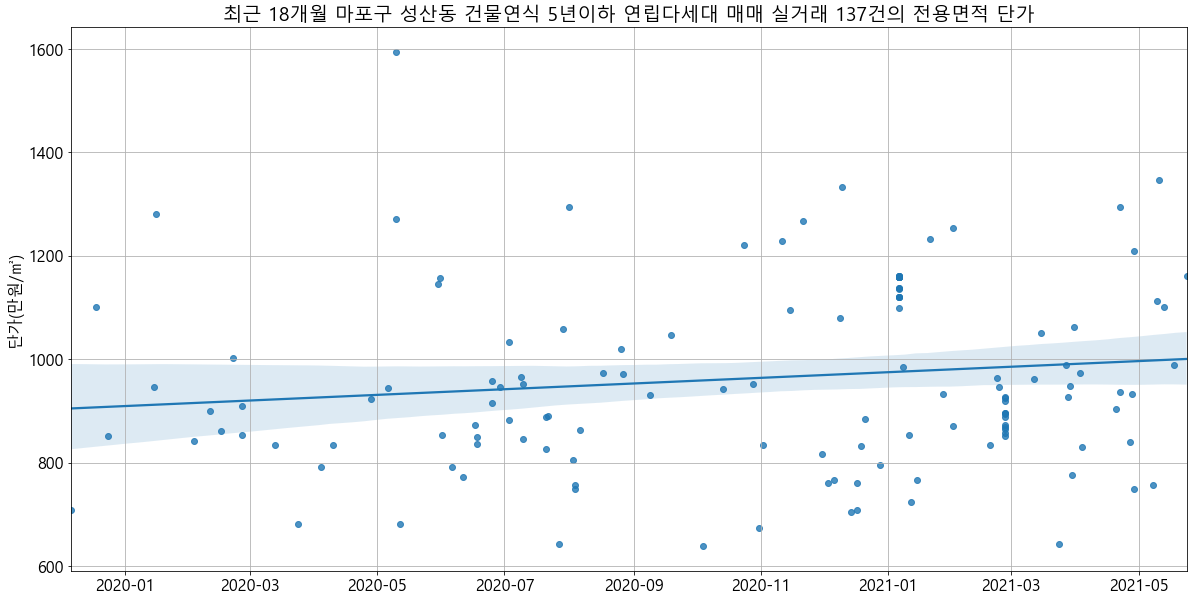

In [20]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [21]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

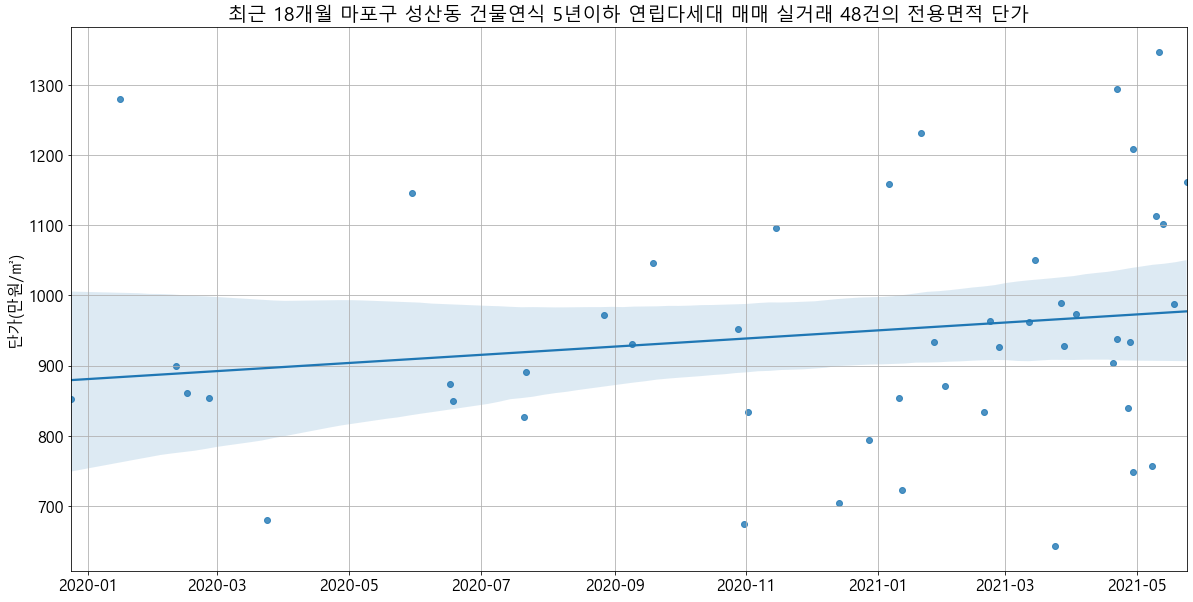

In [22]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [23]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [24]:
target_df2 = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(1753, 23)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
146031,서울특별시 마포구 성산동 200-0,새터산길 9,화이트빌,28.85,22.63,23000,4,2015.0,1.0,2016-04-21,797.227036,6.0,연립다세대,대,498.0,제2종일반주거지역,지정되지않음,주거기타,완경사,사다리형,세로한면(가),마포구,성산동
146032,서울특별시 마포구 성산동 200-0,새터산길 9,화이트빌,27.55,21.61,21300,2,2015.0,1.0,2016-05-21,773.139746,6.0,연립다세대,대,498.0,제2종일반주거지역,지정되지않음,주거기타,완경사,사다리형,세로한면(가),마포구,성산동
146033,서울특별시 마포구 성산동 200-0,새터산길 9,화이트빌,43.97,34.50,28000,3,2015.0,1.0,2016-06-03,636.797817,6.0,연립다세대,대,498.0,제2종일반주거지역,지정되지않음,주거기타,완경사,사다리형,세로한면(가),마포구,성산동
146034,서울특별시 마포구 성산동 200-0,새터산길 9,화이트빌,28.85,22.63,23500,2,2015.0,1.0,2016-06-03,814.558059,6.0,연립다세대,대,498.0,제2종일반주거지역,지정되지않음,주거기타,완경사,사다리형,세로한면(가),마포구,성산동
146035,서울특별시 마포구 성산동 200-0,새터산길 9,화이트빌,43.97,34.50,27900,4,2015.0,1.0,2016-07-06,634.523539,6.0,연립다세대,대,498.0,제2종일반주거지역,지정되지않음,주거기타,완경사,사다리형,세로한면(가),마포구,성산동


In [25]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'마포구 성산동 계약날짜기준 건물연식 5년이하 연립다세대 매매 실거래 1753건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

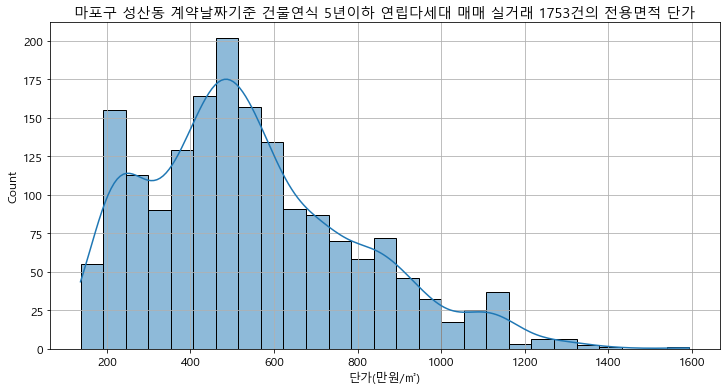

In [26]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_house, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [27]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [28]:
concat_df = pd.concat([target_df2])

In [29]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [30]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [31]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(922, 27)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 마포구 성산동 108-2,월드컵북로18길 8,덕산노블하우스,61.08,27.94,24000,2,2003.0,5.0,2008-04-26,392.927308,18.0,연립다세대,대,223.5,제3종일반주거지역,지정되지않음,다세대,평지,가로장방,소로각지,마포구,성산동,521.662648,2021-03-01,392.927308,521.662648
1,서울특별시 마포구 성산동 111-10,월드컵북로12안길 34-17,sweet seoul residence,14.04,10.64,10500,2,2013.0,4.0,2017-04-02,747.863248,8.0,연립다세대,대,181.5,제2종일반주거지역,지정되지않음,다세대,평지,자루형,세로한면(가),마포구,성산동,966.378566,2021-03-01,658.040362,850.310673
2,서울특별시 마포구 성산동 111-10,월드컵북로12안길 34-17,sweet seoul residence,15.30,11.58,11500,3,2013.0,4.0,2017-04-02,751.633987,8.0,연립다세대,대,181.5,제2종일반주거지역,지정되지않음,다세대,평지,자루형,세로한면(가),마포구,성산동,971.251063,2021-03-01,658.040362,850.310673
3,서울특별시 마포구 성산동 111-10,월드컵북로12안길 34-17,sweet seoul residence,19.44,14.72,12500,3,2013.0,4.0,2017-04-02,643.004115,8.0,연립다세대,대,181.5,제2종일반주거지역,지정되지않음,다세대,평지,자루형,세로한면(가),마포구,성산동,830.881042,2021-03-01,658.040362,850.310673
4,서울특별시 마포구 성산동 111-10,월드컵북로12안길 34-17,sweet seoul residence,34.51,26.12,22000,5,2013.0,4.0,2017-04-02,637.496378,8.0,연립다세대,대,181.5,제2종일반주거지역,지정되지않음,다세대,평지,자루형,세로한면(가),마포구,성산동,823.764020,2021-03-01,658.040362,850.310673


In [32]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(295, 27)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 마포구 성산동 108-2,월드컵북로18길 8,덕산노블하우스,61.080,27.94,24000,2,2003.0,5.0,2008-04-26,392.927308,18.0,연립다세대,대,223.5,제3종일반주거지역,지정되지않음,다세대,평지,가로장방,소로각지,마포구,성산동,521.662648,2021-03-01,392.927308,521.662648
5,서울특별시 마포구 성산동 111-10,월드컵북로12안길 34-17,sweet seoul residence,49.000,37.08,25000,4,2013.0,4.0,2017-04-02,510.204082,8.0,연립다세대,대,181.5,제2종일반주거지역,지정되지않음,다세대,평지,자루형,세로한면(가),마포구,성산동,659.278672,2021-03-01,658.040362,850.310673
8,서울특별시 마포구 성산동 111-14,월드컵북로12안길 34-5,진영시티파크,68.730,43.45,30000,3,2011.0,0.0,2011-12-28,436.490615,10.0,연립다세대,대,389.4,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),마포구,성산동,608.795287,2021-03-01,459.115098,640.350784
13,서울특별시 마포구 성산동 113-4,월드컵북로12안길 16,나오스빌,80.790,41.76,11280,2,2001.0,5.0,2006-07-04,139.621240,20.0,연립다세대,대,290.6,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,소로한면,마포구,성산동,318.216749,2021-03-01,158.373115,345.970616
16,서울특별시 마포구 성산동 128-9,성암로 19,성재센트리움,38.890,24.46,37800,2,2018.0,2.0,2020-08-27,971.972229,3.0,연립다세대,대,99.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,중로한면,마포구,성산동,1044.549086,2021-03-01,941.846533,1064.278578
17,서울특별시 마포구 성산동 13-16,성미산로11길 40,지우주택,78.110,37.39,15300,1,2001.0,5.0,2006-03-21,195.877609,20.0,연립다세대,대,329.9,제2종일반주거지역,지정되지않음,주거기타,평지,세로장방,소로한면,마포구,성산동,475.674066,2021-03-01,195.877609,475.674066
18,서울특별시 마포구 성산동 13-18,월드컵북로16길 38,성산하이츠빌,75.500,34.50,15500,3,2001.0,5.0,2006-09-04,205.298013,20.0,연립다세대,대,276.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,소로한면,마포구,성산동,434.223843,2021-03-01,205.298013,434.223843
19,서울특별시 마포구 성산동 13-19,성미산로11길 46,삼성쉐르빌,75.100,56.90,19000,5,2002.0,5.0,2007-05-03,252.996005,19.0,연립다세대,대,455.2,제2종일반주거지역,지정되지않음,다세대,평지,자루형,소로한면,마포구,성산동,445.200461,2021-03-01,252.996005,445.200461
26,서울특별시 마포구 성산동 13-23,성미산로13길 35,(13-23),17.460,13.37,7500,5,2013.0,1.0,2014-12-22,429.553265,8.0,연립다세대,대,313.4,제2종일반주거지역,지정되지않음,단독,평지,자루형,세로한면(가),마포구,성산동,629.995726,2021-03-01,476.002112,698.119001
36,서울특별시 마포구 성산동 131-1,모래내로9길 13,유일빌리지1단지,50.480,32.05,36500,5,2016.0,5.0,2021-01-12,723.058637,5.0,연립다세대,대,686.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,소로각지,마포구,성산동,728.608792,2021-03-01,758.186527,947.903729


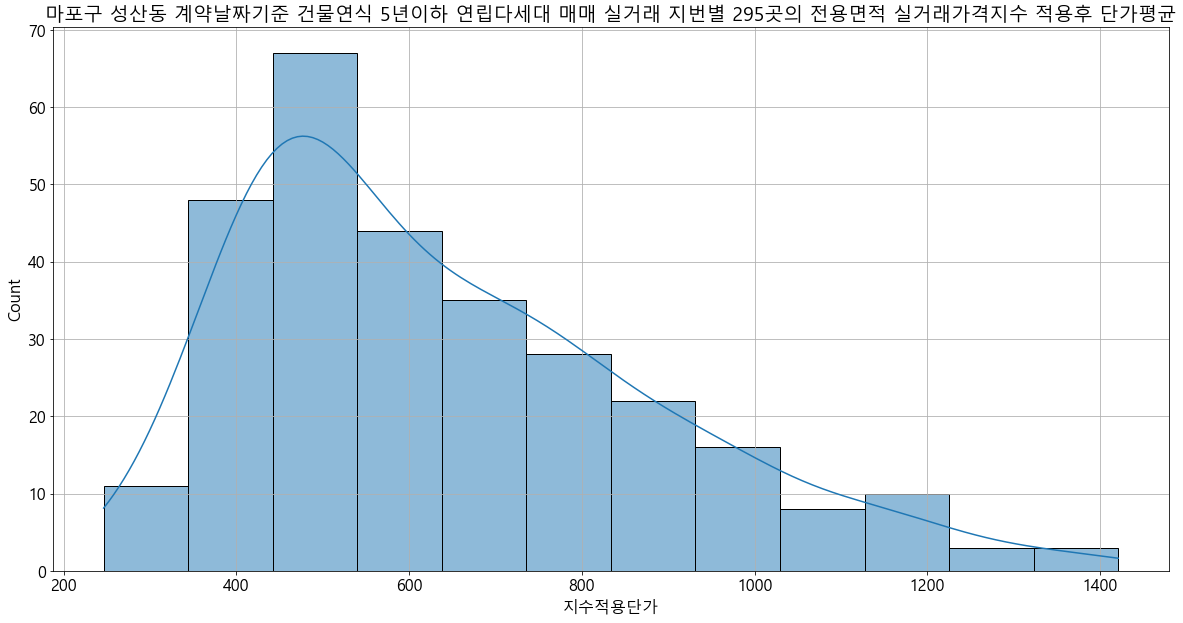

In [33]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [34]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [35]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,용도지역명1,부동산유형
0,서울특별시 마포구 성산동 108-2,덕산노블하우스,2003.0,61.08,2008-04-26,392.927308,2021-03-01,521.662648,제3종일반주거지역,연립다세대
1,서울특별시 마포구 성산동 111-10,sweet seoul residence,2013.0,49.00,2017-04-02,510.204082,2021-03-01,659.278672,제2종일반주거지역,연립다세대
2,서울특별시 마포구 성산동 111-14,진영시티파크,2011.0,68.73,2011-12-28,436.490615,2021-03-01,608.795287,제2종일반주거지역,연립다세대
3,서울특별시 마포구 성산동 113-4,나오스빌,2001.0,80.79,2006-07-04,139.621240,2021-03-01,318.216749,제2종일반주거지역,연립다세대
4,서울특별시 마포구 성산동 128-9,성재센트리움,2018.0,38.89,2020-08-27,971.972229,2021-03-01,1044.549086,제2종일반주거지역,연립다세대


In [36]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)